In [39]:
import os 
from pathlib import Path 

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

import torchsummary 

from torchvision import transforms 
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

import numpy as np

import seaborn as sns
from matplotlib import colors, pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline
plt.style.use('Solarize_Light2')

DEVICE = torch.device('cuda')
GPU = torch.cuda.is_available()
!nvidia-smi 

Fri Jan 24 21:19:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |   6427MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [52]:
params = {
    'data_home': './scikit_learn_data', # default ~/scikit_learn_data
    'resize': 0.7, # default 0.5 and size(62,47), we will have size(87,65)
    'min_faces_per_person': 20,
    'color': True, # 3 RGB channels, +1 dimension 
}
 
lfw_dataset = fetch_lfw_people(**params)
lfw_dataset.data.shape, lfw_dataset.images.shape, lfw_dataset.target.shape, lfw_dataset.target_names.shape

((3023, 16965), (3023, 87, 65, 3), (3023,), (62,))

In [0]:
print(lfw_dataset.DESCR)

In [0]:
# Count images num per class 
labs, counts = np.unique(lfw_dataset.target, return_counts=True)

# plot horizontal bar to make sure we are dealing with Imbalanced dataset
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.barplot(counts, lfw_dataset.target_names[labs], palette='pastel', ax=ax)
sns.despine(left=True, bottom=True)
ax.set_xlabel('image num per person')
ax.set_ylabel('Person Face')
plt.show()

In [0]:
params = {
    'test_size': 0.2,
    'random_state': 33,
    'stratify': lfw_dataset.target_names[lfw_dataset.target]
}
x_tr, x_test, y_tr, y_test = train_test_split(lfw_dataset.images, lfw_dataset.target, **params)

In [0]:
def imshow(img, title='', ax=plt):
  # Normalization params for train dataset 
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  if isinstance(img, np.ndarray):
    # Normalization -> (-1, 1) float
    img = (img - img.mean(axis=(0, 1))) / img.std(axis=(0, 1))

    # Normalization -> (0, 1) float
    img = img * std + mean

  else:
    # .data to access the underlying Tensor, Explanation: https://stackoverflow.com/questions/51743214/is-data-still-useful-in-pytorch
    # some operations cannot be performed in 'cuda', moving to cpu()
    # Pytorch tensors assume the color channel in the first dimension 
    # but matplotlib assumes is the third dimension 
    img = img.data.cpu().numpy().transpose((1, 2, 0))

    # Undo preprocessing
    img = img * std + mean 

  # Image needs to be clipped between 0 and 1 in case we don't want to see the noise displayed
  img = np.clip(img, 0, 1)

  ax.imshow(img)
  ax.grid(False)
  ax.set_title(title)

def plt_images(imgs, labs=None, title='', nrows=4, ncols=4, figsize=(10, 10)):
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True, sharey=True)
  if labs is not None: 
    for ax in axes.flatten():
      ind = int(np.random.uniform(0, len(labs), 1))   
      img, lab = imgs[ind], labs[ind]
      imshow(img, lab, ax)
  else:
    for ind, ax in enumerate(axes.flatten()):
      imshow(imgs[ind], '', ax)

  plt.suptitle(title)

def plot_encoded_images(imgs, labs=None, title=''):
  plt_images(imgs, labs, title)

def plt_images_with_mode(imgs, labs, cls=None, mode='all', title=''):
  if mode == 'all': # randomly plot from all image dataset
    plt_images(imgs, labs, title)
  elif mode == 'rare': # randomly plot from top 10 rare image classes
    cls, counts = np.unique(labs, return_counts=True)
    # dict(class_name, counts) with size(10) 
    rare_cls = dict(sorted(zip(cls, counts), key=lambda x: x[1])[:10])
    inds = np.isin(labs, list(rare_cls.keys()))
    plt_images(imgs[inds], labs[inds], title)
  elif mode == 'exact': # randomly plot from exact classes
    if not cls:
      raise Exception('')
    inds = np.isin(labs, cls)
    plt_images(imgs[inds], labs[inds], title)

In [0]:
plt_images_with_mode(x_tr, lfw_dataset.target_names[y_tr], title='From all photos on train set')

In [0]:
plt_images_with_mode(x_tr, lfw_dataset.target_names[y_tr], mode='rare', title='From rare photos on train set')

In [0]:
class LfwDataset(Dataset):
  ''' lfw_dataset with face images '''
  def __init__(self, dataset, labels=None, compose=None):
    super().__init__()
    self.dataset = dataset
    # In our case we don't have to pass labels of classes
    self.labels = labels

    if not compose:
      compose = transforms.Compose([
                                    transforms.ToTensor(), # transforms numpy array with dimensions (H, W, rgb) -> tensor (rgb, H, W) 
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
    self.transform = compose

    self.len_ = len(dataset)

  def _prepare(self, x):
    print(x.shape)
    if len(x.shape) == 3: 
      mean = x.mean(axis=(0, 1))
      std = x.std(axis=(0, 1))
      return (x - mean) / std

  def __len__(self):
    return self.len_ 

  def __getitem__(self, ind):
      x = self.dataset[ind]
      x = self._prepare(x)
      x = self.transform(x)

      if self.labels:
        return x, self.labels[ind]
      return x


def make_sampler(labs):
  cls, counts = np.unique(labs, return_counts=True)
  weights = 1 / torch.tensor(counts, dtype=torch.float)
  sample_weights = weights[labs]
  sampler = WeightedRandomSampler(
      weights=sample_weights,
      num_samples=len(sample_weights),
      replacement=True
  )
  return sampler 

compose = transforms.Compose([
                              transforms.ToTensor(), # transforms numpy array with dimensions (H, W, rgb) -> tensor (rgb, H, W) 
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ])
transform = {
    'train': compose,
    'test': compose,
    'aug_train': None
}

In [65]:
class UnderCompleteEncoder(nn.Module):
  def __init__(self, in_dim, mid_dim, out_dim):
    super().__init__()
    # Encoder: affine function 
    self.fc1 = nn.Linear(in_dim, mid_dim)
    # Decoder: affine function 
    self.fc2 = nn.Linear(mid_dim, out_dim)
    
    self.dims = [in_dim, mid_dim, out_dim] 

  def forward(self, x):
    # Tensor size(16, 3, 87, 65): flatten tensor to size (16, 3 * 87 * 65)
    x = x.view(-1, self.dims[0])

    # Encoder: affine function 
    x = self.fc1(x)
    # Encoder: non-linear function 
    x = F.relu(x)

    # Decoder: affine function 
    x = self.fc2(x)
    # Decoder: non-linear function 
    x = F.softmax(x)
    return x.view(-1, 3, 87, 65)

net_params = {
    'in_dim': 3 * 87 * 65,
    'mid_dim': int(3 * 87 * 65 * 1.2),
    'out_dim': 3 * 87 * 65
}
uc_encoder = UnderCompleteEncoder(**net_params).to(DEVICE)

torchsummary.summary(uc_encoder, (3, 87, 65), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [16, 20358]     345,393,828
            Linear-2                [16, 16965]     345,390,435
Total params: 690,784,263
Trainable params: 690,784,263
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.04
Forward/backward pass size (MB): 4.56
Params size (MB): 2635.13
Estimated Total Size (MB): 2640.72
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
dataset = LfwDataset(x_tr, compose=compose)
tr_loader_params = {
    'dataset': dataset,
    'batch_size': 16,
    'shuffle': True,
    # 'sampler': make_sampler(y_tr),
    'num_workers': 2,
}
tr_loader = DataLoader(**tr_loader_params)

In [0]:
imgs = next(iter(tr_loader))
print(imgs[0])
plot_encoded_images(imgs)

In [38]:
next(iter(tr_loader))[0].requires_grad

False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1, 1, 389.4088125


2, 1, 370.21834375


3, 1, 375.7229375


4, 1, 393.75590625

The end ... 


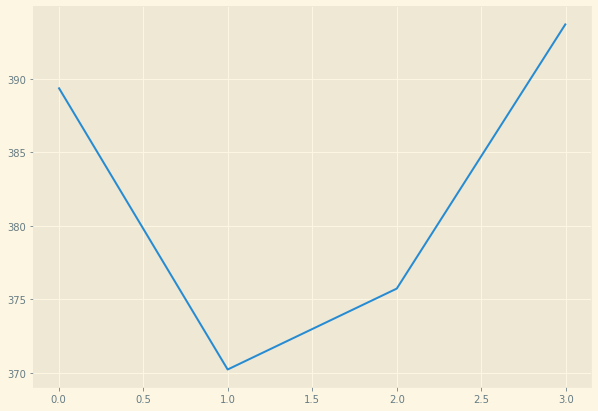

In [40]:
optim_params = {
    'lr': 1e-3,
}
optimizer = optim.Adam(uc_encoder.parameters(), **optim_params)

criterion = nn.MSELoss()

epoch = 4
losses = []
for epoch in tqdm_notebook(range(epoch)):
  running_loss = .0
  for i, batch in enumerate(tqdm_notebook(tr_loader)):
    optimizer.zero_grad()

    batch = batch.to(DEVICE).requires_grad_(True)

    pred = uc_encoder(batch)
    loss = criterion(pred, batch)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if i % 1000 == 0:
      print(f'{epoch + 1}, {i + 1}, {running_loss / 1000}')
      losses.append(running_loss / 1000)
      running_loss = .0
print('The end ... ')
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses)), losses)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


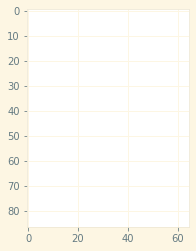

In [51]:
plt.imshow(next(iter(tr_loader))[0].data.cpu().numpy().transpose((1, 2, 0)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


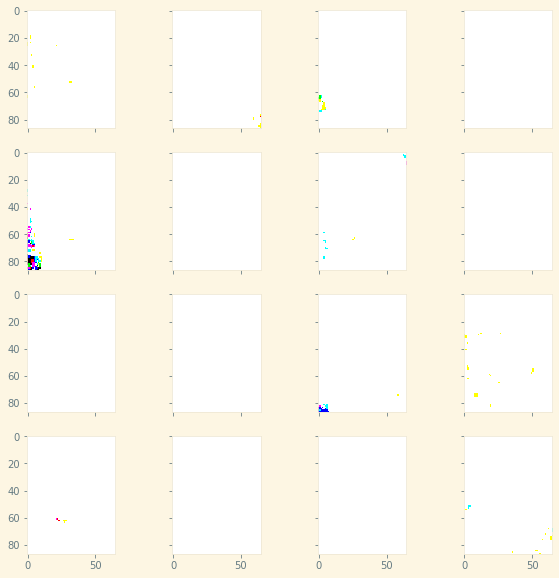

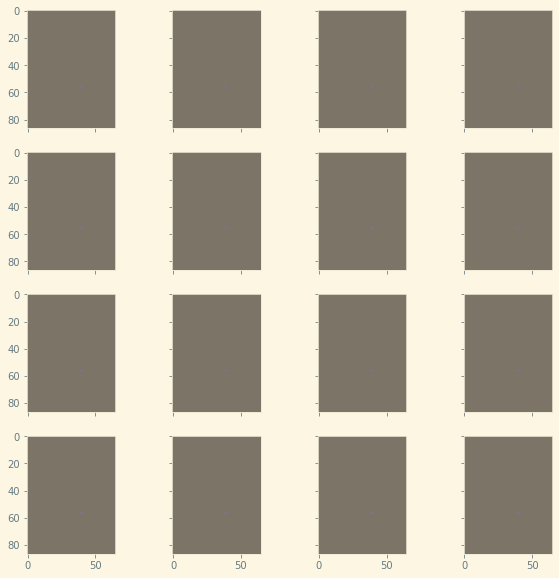

In [43]:
imgs = None 
with torch.no_grad():
  imgs = next(iter(tr_loader)).to(DEVICE)
  uc_encoder.eval()
  decoded_imgs = uc_encoder(imgs)

plot_encoded_images(imgs)
plot_encoded_images(decoded_imgs)